In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import json

This notebook uses the target-decoy classifier to classify the feature metrics as a target or a decoy. It uses the following files from the BAM:

- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.211.113.236:~/experiments/dwm-test/recalibrated-percolator-output/*percolator.log.txt ~/Downloads/experiments/dwm-test/recalibrated-percolator-output/

- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.211.113.236:~/experiments/dwm-test/target-decoy-models/target-decoy-classifier.pkl ~/Downloads/experiments/dwm-test/target-decoy-models/

- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.211.113.236:~/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl ~/Downloads/experiments/dwm-test/target-decoy-models/

- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.211.113.236:~/experiments/dwm-test/sequence-library/percolator-id-feature-mapping.pkl ~/Downloads/experiments/dwm-test/sequence-library/

The notebook creates the sequences_with_species_df dataframe (SEQUENCES_WITH_SPECIES_FILE_NAME), which is each library sequence in each run classified as target or decoy. Each sequence is also annotated with whether it is human or not, and which 1to1 or 1to3 batch it's in. This dataframe is used by subsequent notebooks.

In [2]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = list(df.itertuples(index=False, name=None))    
    return mapping_l


In [3]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
TEMP_DIR = '/home/ubuntu'

In [4]:
TARGET_DECOY_MODEL_DIR = '{}/target-decoy-models'.format(EXPERIMENT_DIR)

In [5]:
EXPERIMENT_METRICS_FILE_NAME = "{}/experiment-metrics-for-library-sequences.pkl".format(TARGET_DECOY_MODEL_DIR)
CLASSIFIER_FILE_NAME = "{}/target-decoy-classifier.pkl".format(TARGET_DECOY_MODEL_DIR)
PERCOLATOR_STDOUT_FILE_NAME = "{}/recalibrated-percolator-output/dwm-test.percolator.log.txt".format(EXPERIMENT_DIR)
PERCOLATOR_ID_FEATURE_MAPPING_FILE_NAME = "{}/sequence-library/percolator-id-feature-mapping.pkl".format(EXPERIMENT_DIR)
SEQUENCES_WITH_SPECIES_FILE_NAME = '{}/sequences-with-species-df.pkl'.format(TEMP_DIR)
SEQUENCES_WITH_SPECIES_CSV_FILE_NAME = '{}/sequences-with-species-df.csv'.format(TEMP_DIR)
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)
METRICS_DB_NAME = "{}/experiment-metrics-for-library-sequences.sqlite".format(TARGET_DECOY_MODEL_DIR)

In [6]:
db_conn = sqlite3.connect(METRICS_DB_NAME)
experiment_metrics_for_library_sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,target_metrics,attributes from extracted_metrics', db_conn)
db_conn.close()


In [7]:
len(experiment_metrics_for_library_sequences_df)

1328134

In [8]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_metrics',
       'attributes'],
      dtype='object')

In [9]:
with open(CLASSIFIER_FILE_NAME, 'rb') as file:
    gbc = pickle.load(file)


In [10]:
# unpack the target metrics from each sequence
metrics = []
metric_names = [key for key in sorted(json.loads(experiment_metrics_for_library_sequences_df.iloc[0].target_metrics))]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric values
    d = json.loads(row.target_metrics)
    if ((d is not None) and (isinstance(d, dict))):
        l = []
        l.append(row.sequence)
        l.append(row.charge)
        l.append(row.file_idx)
        l.append(int(row.peak_idx))
        l += [d[key] for key in sorted(d)]
        metrics.append(tuple(l))

columns = ['sequence','charge','file_idx','peak_idx']
columns += metric_names

metrics_df = pd.DataFrame(metrics, columns=columns)

# tidy up any attributes that will upset the model training
metrics_df.fillna(value=0.0, inplace=True)
metrics_df.r_squared_phr.replace((-np.inf, 0), inplace=True)

In [11]:
# unpack the attributes from each sequence
attributes = []

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # attribute values
    d = json.loads(row.attributes)
    if ((d is not None) and (isinstance(d, dict))):
        l = []
        l.append(row.sequence)
        l.append(row.charge)
        l.append(row.file_idx)
        l.append(int(row.peak_idx))
        l.append(d['intensity'])
        l.append(d['isotope_idx_not_in_saturation'])
        attributes.append(tuple(l))

columns = ['sequence','charge','file_idx','peak_idx','intensity','isotope_idx_not_in_saturation']

attributes_df = pd.DataFrame(attributes, columns=columns)


In [12]:
# create the set to be classified
X = metrics_df[metric_names].values

In [13]:
metrics_df.sample(n=5)

,sequence,charge,file_idx,peak_idx,delta_mz_ppm,delta_rt,delta_scan,fwhm_rt_0,fwhm_scan_0,geometric_mean_0_1,...,peak_base_width_scan_0,r_squared_phr,rt_isotope_correlation,rt_peak_symmetry_0,rt_peak_symmetry_1,rt_peak_symmetry_2,scan_isotope_correlation,scan_peak_symmetry_0,scan_peak_symmetry_1,scan_peak_symmetry_2
813059,ENFQNWLK,2,2,2,-1.197464,0.021074,0.021332,3.816658,4.3175,10.337151,...,11.0,-23.538286,0.005021,2.533721,2.562222,1.161491,0.135826,1.146067,2.842593,1.845921
292784,HQDFNSAVQLVENFCR,2,15,1,0.072253,0.013929,-0.013080,3.583069,4.7100,10.401052,...,12.0,-1.598177,0.020964,1.506365,1.049728,0.768634,0.275326,0.792866,0.867426,1.159686
168260,LIEAEDNMNCQM[15.9949]SNITVTYR,2,8,1,1.396633,0.015730,0.073080,3.184251,6.6725,8.583379,...,17.0,0.026506,0.000000,3.388350,1.379482,2.787190,0.142746,1.383838,2.201323,1.926471
719075,TETEFPDEDEETR,2,17,1,1.530585,0.033771,-0.092046,4.606747,4.7100,11.854461,...,12.0,-69.174435,-0.037757,2.233653,1.576903,1.157622,0.026645,1.568182,0.780384,1.292162
1217784,GPVKPTGGPGGGGTQTQQQMNQLK,2,14,0,-0.606125,-0.005037,0.036767,1.458570,9.0275,9.183714,...,23.0,0.783372,0.042589,1.225086,2.941720,1.003991,0.068463,2.117384,2.981047,1.118256


In [14]:
attributes_df.sample(n=5)

,sequence,charge,file_idx,peak_idx,intensity,isotope_idx_not_in_saturation
240056,MPTTQETDGFQVK,2,4,0,194,0.0
699433,LMQITSLHSLNAFLLPIK,3,17,0,268,0.0
695811,LALQWHPDNFQNEEEK,3,17,1,441,0.0
653526,TVVQSCGHSLETK,2,3,1,340,0.0
938536,DENSVELTMAEGPYK,2,10,2,279,0.0


In [15]:
# classify the set
predictions = gbc.predict(X)

In [16]:
# add a column for the classification result
classified_features_df = metrics_df[['sequence','charge','file_idx','peak_idx']].copy()
classified_features_df['classed_as'] = predictions.tolist()

In [17]:
# show how many sequences were classified as targets
len(classified_features_df[classified_features_df.classed_as == 'target']), len(classified_features_df[classified_features_df.classed_as == 'decoy'])

(985525, 342609)

In [18]:
mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)

In [19]:
mapping_l

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to1_09'),
 (3, '190719_Hela_Ecoli_1to3_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_01'),
 (6, '190719_Hela_Ecoli_1to1_03'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to1_10'),
 (9, '190719_Hela_Ecoli_1to3_07'),
 (10, '190719_Hela_Ecoli_1to1_08'),
 (11, '190719_Hela_Ecoli_1to1_01'),
 (12, '190719_Hela_Ecoli_1to3_04'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_10'),
 (15, '190719_Hela_Ecoli_1to1_04'),
 (16, '190719_Hela_Ecoli_1to1_02'),
 (17, '190719_Hela_Ecoli_1to3_02'),
 (18, '190719_Hela_Ecoli_1to1_05'),
 (19, '190719_Hela_Ecoli_1to1_06')]

In [20]:
mapping_df = pd.DataFrame([(l[0],l[1]) for l in mapping_l], columns=['file_idx','run_name'])

In [21]:
mapping_df['batch'] = mapping_df.run_name.apply(lambda x: x.split('_')[3])

In [22]:
# join them all together
sequences_df = pd.merge(experiment_metrics_for_library_sequences_df, metrics_df, how='left', left_on=['sequence','charge','file_idx','peak_idx'], right_on=['sequence','charge','file_idx','peak_idx'])
sequences_df = pd.merge(sequences_df, attributes_df, how='left', left_on=['sequence','charge','file_idx','peak_idx'], right_on=['sequence','charge','file_idx','peak_idx'])
sequences_df = pd.merge(sequences_df, classified_features_df, how='left', left_on=['sequence','charge','file_idx','peak_idx'], right_on=['sequence','charge','file_idx','peak_idx'])
sequences_df = pd.merge(sequences_df, mapping_df, how='left', left_on=['file_idx'], right_on=['file_idx'])

In [23]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_metrics',
       'attributes', 'delta_mz_ppm', 'delta_rt', 'delta_scan', 'fwhm_rt_0',
       'fwhm_scan_0', 'geometric_mean_0_1', 'geometric_mean_0_1_2',
       'isotope_0_1_mz_delta_ppm', 'isotope_0_1_rt_delta',
       'isotope_0_1_scan_delta', 'isotope_0_2_mz_delta_ppm',
       'isotope_0_2_rt_delta', 'isotope_0_2_scan_delta',
       'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_peak_symmetry_0', 'rt_peak_symmetry_1',
       'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_peak_symmetry_0', 'scan_peak_symmetry_1', 'scan_peak_s

In [24]:
# take the sequences classified as targets
target_features_df = sequences_df[(sequences_df.classed_as == 'target') & (sequences_df.intensity > 0)]

In [25]:
target_features_df[['isotope_idx_not_in_saturation']].head()

,isotope_idx_not_in_saturation
3,0.0
4,0.0
5,0.0
6,0.0
8,0.0


In [26]:
# if there are multiple peaks for a sequence/charge/file_idx, take the peak with the smallest m/z delta from the estimated m/z apex
selected_peaks_l = []
for group_name,group_df in target_features_df.groupby(['sequence','charge','file_idx'], as_index=False):
    selected_peaks_l.append(group_df.loc[group_df.delta_mz_ppm.idxmin()])
sequences_df = pd.DataFrame(selected_peaks_l)

In [27]:
sequences_df.sample(n=5)

,sequence,charge,file_idx,peak_idx,target_metrics,attributes,delta_mz_ppm,delta_rt,delta_scan,fwhm_rt_0,...,rt_peak_symmetry_2,scan_isotope_correlation,scan_peak_symmetry_0,scan_peak_symmetry_1,scan_peak_symmetry_2,intensity,isotope_idx_not_in_saturation,classed_as,run_name,batch
726241,VPDGLDSAAASSITCAGVTTYK,2,17,0.0,"{""delta_mz_ppm"": 0.6955306864771559, ""delta_rt...","{""intensity"": 3920, ""inferred"": 0, ""isotope_id...",0.695531,-0.000319,-0.032842,3.858377,...,0.887487,0.440397,0.817206,0.717949,1.003943,3920,0.0,target,190719_Hela_Ecoli_1to3_02,1to3
707312,NQLRDEVDR,2,17,0.0,"{""delta_mz_ppm"": -1.108898429510213, ""delta_rt...","{""intensity"": 2906, ""inferred"": 0, ""isotope_id...",-1.108898,0.005745,0.006551,2.696580,...,2.558622,0.286720,1.775989,2.911817,3.519945,2906,0.0,target,190719_Hela_Ecoli_1to3_02,1to3
45544,QIPVLQTNNGPSLTGLTTIAAHLVK,3,13,0.0,"{""delta_mz_ppm"": 0.542963819913348, ""delta_rt""...","{""intensity"": 463, ""inferred"": 0, ""isotope_idx...",0.542964,-0.000528,0.005315,2.704776,...,1.783158,0.213073,0.766108,0.406703,1.511912,463,0.0,target,190719_Hela_Ecoli_1to3_03,1to3
119165,SGGGGDIHQGFQSLLTEVNK,2,9,1.0,"{""delta_mz_ppm"": -2.6829160817639077, ""delta_r...","{""intensity"": 381, ""inferred"": 0, ""isotope_idx...",-2.682916,0.057584,-0.015874,3.479552,...,1.495577,0.270964,1.177200,1.691272,6.251082,381,0.0,target,190719_Hela_Ecoli_1to3_07,1to3
591943,WAPDGSCILTNSADNILR,2,1,0.0,"{""delta_mz_ppm"": -1.4481796975959442, ""delta_r...","{""intensity"": 217, ""inferred"": 0, ""isotope_idx...",-1.448180,0.003181,-0.038501,2.549555,...,1.144176,0.114010,1.653122,0.557760,1.113511,217,0.0,target,190719_Hela_Ecoli_1to1_07,1to1


In [28]:
sequence_occurences_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df), group_name[0], group_name[1]))

In [29]:
sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['group','frequency','sequence','charge'])

In [30]:
sequence_occurences_df.sample(n=5)

,group,frequency,sequence,charge
23761,"(SMASGGGVPTDEEQATGLER, 2)",20,SMASGGGVPTDEEQATGLER,2
20739,"(QITAQAWDGTTDYQVEETSR, 2)",20,QITAQAWDGTTDYQVEETSR,2
25306,"(TGISHGHTVYVVHDGFEGLAK, 4)",20,TGISHGHTVYVVHDGFEGLAK,4
18241,"(MIMALVSDSALFNTR, 2)",18,MIMALVSDSALFNTR,2
9395,"(GEPAVVEPGMLVEGPPGPAGPAGIMGPPGLQGPTGPPGDPGDR, 3)",20,GEPAVVEPGMLVEGPPGPAGPAGIMGPPGLQGPTGPPGDPGDR,3


In [31]:
# add the number of runs the sequence/charge was seen
sequences_df = pd.merge(sequences_df, sequence_occurences_df[['sequence','charge','frequency']], how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])
sequences_df.rename(columns={'frequency': 'number_of_runs_identified'}, inplace=True)

In [32]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_metrics',
       'attributes', 'delta_mz_ppm', 'delta_rt', 'delta_scan', 'fwhm_rt_0',
       'fwhm_scan_0', 'geometric_mean_0_1', 'geometric_mean_0_1_2',
       'isotope_0_1_mz_delta_ppm', 'isotope_0_1_rt_delta',
       'isotope_0_1_scan_delta', 'isotope_0_2_mz_delta_ppm',
       'isotope_0_2_rt_delta', 'isotope_0_2_scan_delta',
       'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_peak_symmetry_0', 'rt_peak_symmetry_1',
       'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_peak_symmetry_0', 'scan_peak_symmetry_1', 'scan_peak_s

In [33]:
modified_sequences_count = len(sequences_df['sequence'].unique())

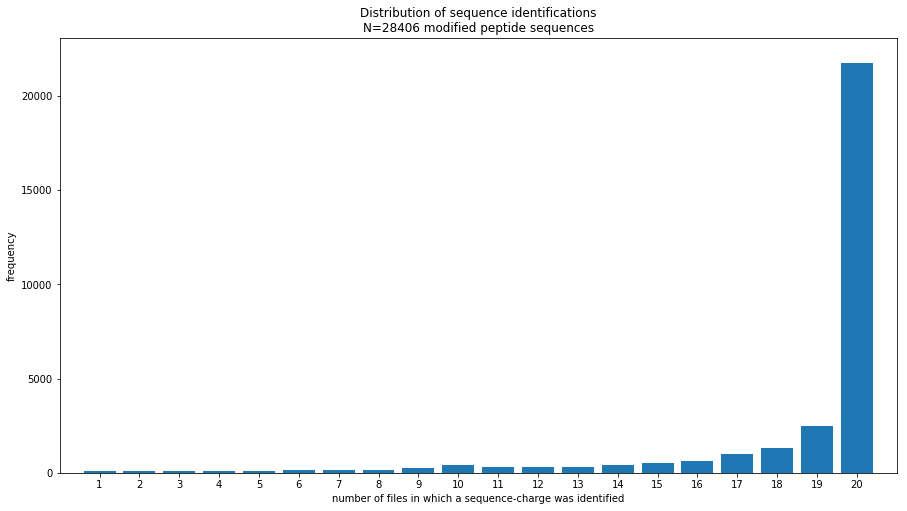

In [34]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Distribution of sequence identifications\nN={} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(sequence_occurences_df.frequency)
ax1.bar(range(21), counts, width=0.8, align='center')
plt.xlabel('number of files in which a sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,21), xlim=[0, 21])
# plt.ylim((0,20000))

plt.show()

In [35]:
sequence_occurences_df['missing_files'] = 20 - sequence_occurences_df.frequency

In [36]:
proportion_of_missing_values = sequence_occurences_df.missing_files.sum() / (len(sequence_occurences_df) * 20)
proportion_of_missing_values

0.07098993398261325

In [37]:
percolator_id_feature_mapping_df = pd.read_pickle(PERCOLATOR_ID_FEATURE_MAPPING_FILE_NAME)

In [38]:
percolator_id_feature_mapping_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'feature_id', 'charge_y',
       'rt_apex', 'rt_peak_width', 'scan_apex', 'scan_peak_width', 'intensity',
       'precursor_id', 'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'percolator_idx', 'human'],
      dtype='object')

In [39]:
# is a sequence-charge ever inferred to more than one species protein?
sequence_charge_species_l = []
for group_name,group_df in percolator_id_feature_mapping_df.groupby(['sequence','charge_x']):
    row = group_df.iloc[0]
    sequence_charge_species_l.append((row.sequence, row.charge_x, row.human))
    if len(group_df.human.unique()) > 1:
        print('yes')

no - a sequence charge, if seen more than once, is always inferred to a protein of the same species

In [40]:
sequence_charge_species_df = pd.DataFrame(sequence_charge_species_l, columns=['sequence','charge','human'])

In [41]:
sequence_charge_species_df.head()

,sequence,charge,human
0,AAAAAAAAAAAAAAAASAGGK,2,True
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,True
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,True
3,AAAAAAAAVPSAGPAGPAPTSAAGR,2,True
4,AAAAALSQQQSLQER,2,True


In [42]:
# add whether the sequence is human
sequences_df = pd.merge(sequences_df, sequence_charge_species_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [43]:
# write out the results for analysis
sequences_df.to_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)
sequences_df[['sequence','charge','file_idx','peak_idx','delta_mz_ppm','delta_rt','delta_scan','intensity','isotope_idx_not_in_saturation','classed_as','run_name','batch','number_of_runs_identified']].to_csv(SEQUENCES_WITH_SPECIES_CSV_FILE_NAME, index=False)


In [44]:
len(sequences_df)

568517

In [45]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [46]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [47]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [48]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

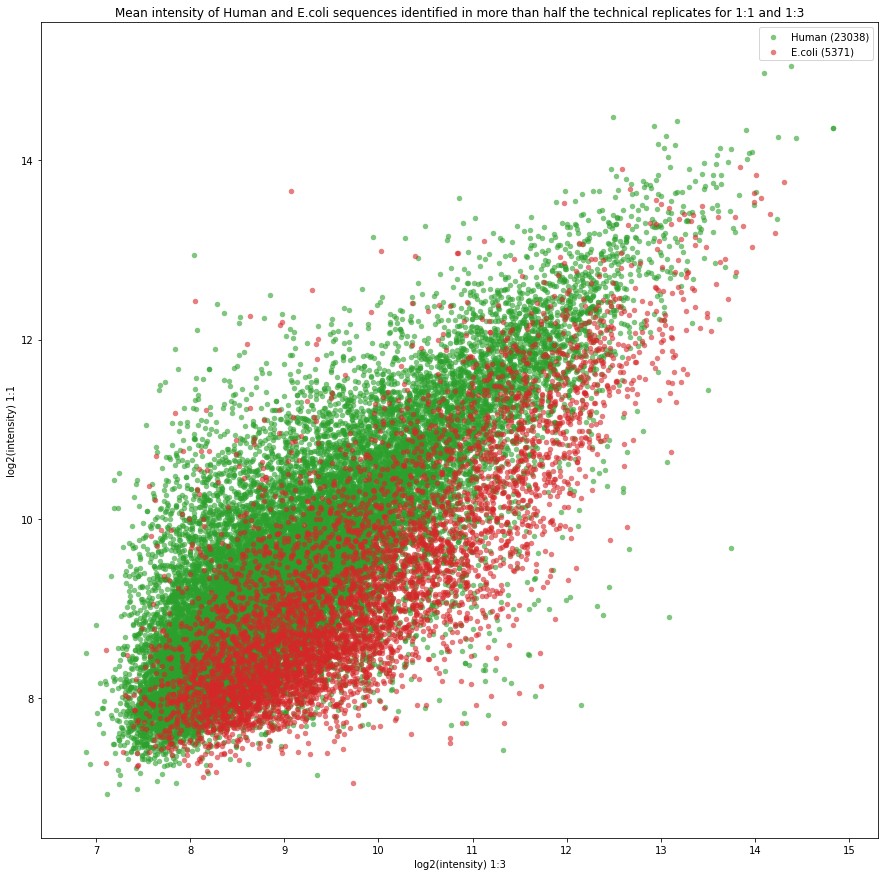

In [49]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

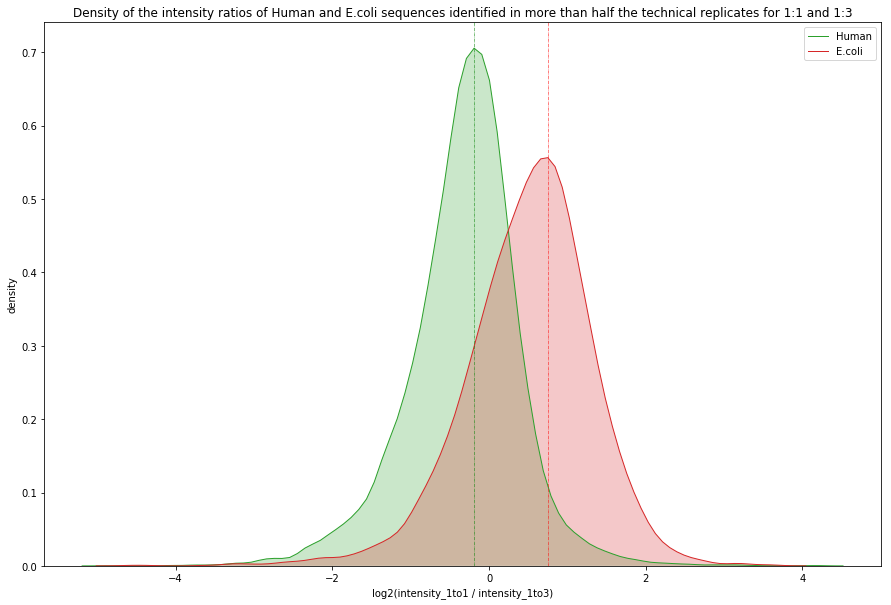

In [50]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')